In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import optimize
from scipy.stats import poisson
import math

In [14]:
#data = np.zeros(shape=num_ev, dtype=[('timeStamp','f4')
data = pd.read_excel('/Users/ibhallaladd/Desktop/Bells_data_test.xlsx', dtype={'Name': str, 'Value': float})

In [15]:
data

,a_pc_0,b_pc_0,nc_pc_0_1,nc_pc_0_2,nc_pc_0_3,a_pc_45,b_pc_45,nc_pc_45_1,nc_pc_45_2,nc_pc_45_3
0,0,0,1.9041,1.6957,1.6873,45,0,1.1696,1.1436,1.1823
1,0,10,1.6709,NaN,NaN,45,10,1.5181,1.4899,1.4951
2,0,20,1.5015,NaN,NaN,45,20,1.6194,1.6321,1.6187
3,0,30,1.2353,NaN,NaN,45,30,1.7549,1.7266,1.7649
4,0,40,0.9736,NaN,NaN,45,40,1.7856,1.7911,1.7772
5,0,50,0.7097,NaN,NaN,45,50,1.7226,1.7262,1.7136
6,0,60,0.4744,NaN,NaN,45,60,1.5388,1.5633,1.6009
7,0,70,0.3267,NaN,NaN,45,70,1.3017,1.3045,1.3441
8,0,80,0.2408,NaN,NaN,45,80,1.0615,1.0743,1.0588
9,0,90,0.2461,0.2219,0.2213,45,90,0.8218,0.7787,0.7777


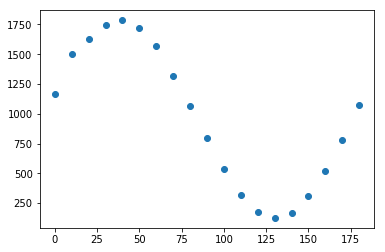

In [26]:
beta = data['b_pc_45']
alpha = data['a_pc_45']
Nc = ((data['nc_pc_45_1']+data['nc_pc_45_2']+data['nc_pc_45_3'])/3)*1000

plt.scatter(beta, Nc)

In [29]:
C_test = 
def N_constance(a, alpha, beta, theta, phim):
    a*((np.sin(alpha)**2)(np.sin(x)**2)(np.cos(theta)**2) + (np.cos(alpha)**2)(np.cos(x)**2)(np.sin(theta)**2) + 0.25(np.sin(2*alpha)*np.sin(2*x)*np.sin(2*theta)*np.cos(phim))) + C
    #return a * np.sin(b*x + d) + c

SyntaxError: invalid syntax (<ipython-input-29-75f25b806e91>, line 1)

In [17]:
C_raw = 255.9 #N(0,90)
A_raw = 1688.8 + 1765.7 + - 2*C_raw #N(0,0) + N(90,90) - 2C
print(A_raw)
ALPHA = 45

2942.7


In [18]:
def herbert(beta, Nc, firstGuess = []):
    #x, A, alpha, theta, phim, C
    #firstGuess=[A_raw, 45, 45, 20, C_raw])
    beta = np.radians(beta)

    A = firstGuess[0]
    alpha = np.radians(firstGuess[1])
    theta = np.radians(firstGuess[2])
    phim = np.radians(firstGuess[3])
    C = firstGuess[4]

    theta_range = np.arange(theta - 0.15 , theta + 0.15, 0.03)
    phim_range = np.arange(phim - 0.15 , phim + 0.15, 0.03)
    A_range = np.arange(A-500, A+500, 50)
    C_range = np.arange(C-100, C+100, 10)
    #alpha_range = np.arange(alpha - 0.05, alpha + 0.05, 0.01)
    alpha_range = np.arange(alpha - 0.15, alpha + 0.15, 0.03)

    optim_theta = 0
    optim_alpha = 0
    optim_phim = 0
    optim_A = 0
    optim_C = 0
    
    #score = (N_global(beta, A_raw, alpha, theta - 1.0, phim - 1.0, C_raw) - Nc)**2
    
    scoreboard = 1000000000000000000000000
    
    for p in range(len(alpha_range)):
        for m in range(len(A_range)):
            for n in range(len(C_range)):
                for i in range(len(theta_range)):
                    for j in range(len(phim_range)):
                        #candidate evaluation starts
                        sum_lsq = 0
                        for k in range(len(beta)):
                            lsq = (N_global(beta[k], A_range[m], np.degrees(alpha_range[p]), np.degrees(theta_range[i]), np.degrees(phim_range[j]), C_range[n]) - Nc[k])**2
                            sum_lsq += lsq
                            #print(sum_lsq)

                        if(sum_lsq < scoreboard):
                            print("surpassed scoreboard")
                            scoreboard = sum_lsq
                            #print("surpassed scoreboard with: " + str(sum_lsq))
                            optim_theta = theta_range[i]
                            optim_phim = phim_range[j]
                            optim_A = A_range[m]
                            optim_C = C_range[n]
                            optim_alpha = alpha_range[p]
                        

    #x, A, alpha, theta, phim, C       
    return optim_A, optim_alpha, optim_theta, optim_phim, optim_C
        
    

In [19]:
def herbert_tits(beta, Nc, firstGuess = []):
    #x, A, alpha, theta, phim, C
    #firstGuess=[A_raw, 45, 45, 20, C_raw])
    #beta = np.radians(beta)

    #dont need to put in radians again
    A = firstGuess[0]
    alpha = firstGuess[1]
    theta = firstGuess[2]
    phim = firstGuess[3]
    C = firstGuess[4]

    theta_range = np.arange(theta - 10, theta + 10, 1)
    phim_range = np.arange(phim - 10 , phim + 10, 1)
    A_range = np.arange(A-500, A+500, 50)
    C_range = np.arange(C-100, C+100, 10)
    #alpha_range = np.arange(alpha - 0.05, alpha + 0.05, 0.01)
    alpha_range = np.arange(alpha - 10, alpha + 10, 1)

    optim_theta = 0
    optim_alpha = 0
    optim_phim = 0
    optim_A = 0
    optim_C = 0
    
    #score = (N_global(beta, A_raw, alpha, theta - 1.0, phim - 1.0, C_raw) - Nc)**2
    
    scoreboard = 1000000000000000000000000
    
    for p in range(len(alpha_range)):
        for m in range(len(A_range)):
            for n in range(len(C_range)):
                for i in range(len(theta_range)):
                    for j in range(len(phim_range)):
                        #candidate evaluation starts
                        sum_lsq = 0
                        for k in range(len(beta)):
                            #print(phim_range[j])
                            lsq = (N_global(beta[k], A_range[m], alpha_range[p], theta_range[i], phim_range[j], C_range[n]) - Nc[k])**2
                            sum_lsq = sum_lsq + lsq
                            #print(sum_lsq)

                        if(sum_lsq < scoreboard):
                            print("surpassed scoreboard")
                            scoreboard = sum_lsq
                            #print("surpassed scoreboard with: " + str(sum_lsq))
                            optim_theta = theta_range[i]
                            optim_phim = phim_range[j]
                            optim_A = A_range[m]
                            optim_C = C_range[n]
                            optim_alpha = alpha_range[p]
                            
    
                        

    #x, A, alpha, theta, phim, C       
    return optim_A, optim_alpha, optim_theta, optim_phim, optim_C
        
    

In [21]:
def herbert_simp(beta, alpha, Nc, firstGuess = []):
    theta = np.radians(firstGuess[0])
    phim = np.radians(firstGuess[1])
    A = firstGuess[2]
    C = firstGuess[3]
    beta = np.radians(beta)
    alpha = np.radians(alpha)
    
    theta_range = np.arange(theta - 1.0 , theta + 1.0, 0.05)
    phim_range = np.arange(phim - 0.05 , phim + 0.05, 0.01)
    A_range = np.arange(A-10, A+10, 1)
    C_range = np.arange(C-0.5, C+0.5, 0.1)

    optim_theta = 0
    optim_phim = 0
    optim_A = 0
    optim_C = 0
    
    #score = (N_global(beta, A_raw, alpha, theta - 1.0, phim - 1.0, C_raw) - Nc)**2
    
    scoreboard = 1000000000000000000000000

    for i in range(len(theta_range)):
        for j in range(len(phim_range)):
            #candidate evaluation starts
            sum_lsq = 0
            for k in range(len(beta)):
                lsq = (N_global(beta[k], A_raw, ALPHA, np.degrees(theta_range[i]), np.degrees(phim_range[j]), C_raw) - Nc[k])**2
                sum_lsq += lsq
                #print(sum_lsq)

            if(sum_lsq < scoreboard):
                #print("surpassed scoreboard")
                scoreboard = sum_lsq
                #print("surpassed scoreboard with: " + str(sum_lsq))
                optim_theta = theta_range[i]
                optim_phim = phim_range[j]
                #optim_A = A_range[m]
                #optim_C = C_range[n]


                
    return optim_theta, optim_phim
   

In [20]:
def N_global(x, A, alpha, theta, phim, C):
    alpha = np.radians(alpha)
    #alpha = np.pi/4
    x = np.radians(x)
    theta = np.radians(theta)
    phim = np.radians(phim)

    return A * (( (np.sin(alpha)**2)*(np.sin(x)**2)*(np.cos(theta)**2) + (np.cos(alpha)**2)*(np.cos(x)**2)*(np.sin(theta)**2)) + 0.25*(np.sin(2*alpha)*np.sin(2*x)*np.sin(2*theta)*np.cos(phim))) + C

#maybe separate optimizations into two separate stages b/c all together takes too long

surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed sco

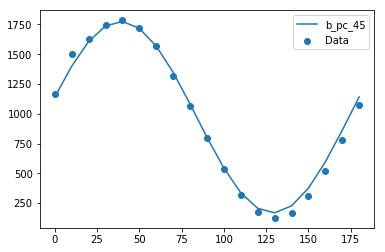

In [43]:
#optimized_theta, optimized_phim, optimized_A, optimized_C = herbert(beta, alpha, Nc, firstGuess=[45, 0.01, A_raw, C_raw])
#38, 20, 3500, 66

optimized_A, optimized_alpha, optimized_theta, optimized_phim, optimized_C = herbert_tits(beta, Nc, firstGuess=[A_raw, 45, 45, 20, C_raw])

print(optimized_theta)
print(optimized_phim)
print(optimized_alpha)

print(optimized_A)
print(optimized_C)

params = [4000, 45, 45, 10, 40]
plt.scatter(beta, Nc, label='Data')
plt.plot(beta, N_global(beta, optimized_A, optimized_alpha, optimized_theta, optimized_phim, optimized_C))
#plt.plot(beta, N_global(beta, A_raw, 45, 45, 20, C_raw))

plt.legend(loc='best')
#plt.ylim(1020, 1050)

plt.show()

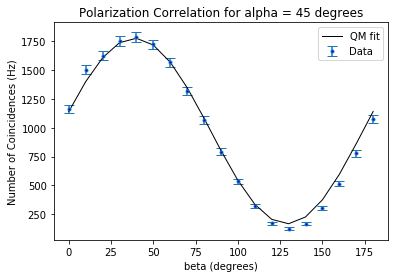

6.561336908262545
1.8439854577781483


In [95]:
#print(optimized_theta)
#print(optimized_phim)
#print(optimized_alpha)

#print(optimized_A)
#print(optimized_C)

#beta = np.arange(0, 18, 1)
#Nc = np.arange(0, 18, 1)

good_run = [3242.7, 40, 46, 10, 155.9]
good_run = [3242.7, 40, 46, 10, 155.9]


yerr = np.zeros(len(Nc))
for i in range(len(Nc)):
    yerr[i] = np.sqrt(Nc[i])


    
    
plt.errorbar(beta, Nc, label='Data',yerr=yerr,marker='.',markerfacecolor='b',linestyle='',capsize=5)
plt.plot(beta, N_global(beta, good_run[0], good_run[1], good_run[2], good_run[3], good_run[4]), label='QM fit',linewidth=1, color='k')
#plt.plot(beta, N_global(beta, A_raw, 45, 45, 20, C_raw))


plt.legend(loc='best')
#plt.ylim(1020, 1050)
plt.title("Polarization Correlation for alpha = 45 degrees")
plt.xlabel("beta (degrees)")
plt.ylabel("Number of Coincidences (Hz)")
plt.savefig('/Users/ibhallaladd/Desktop/pol_cor.png')

plt.show()
#plt.ylabel("Number of Coincidences (#counts)")
#plt.show()

#x, A, alpha, theta, phim, C
chisq = red_chisq(Nc, N_global(beta, good_run[0], good_run[1], good_run[2], good_run[3], good_run[4]),yerr, 5)
old_chisq = chisq
print(old_chisq)
#all plus minus
#Aerr:200
#alpha_err:3.5
#theta_err:1.75
#phim_err:7.5
#Cerr:21
chisq = red_chisq(Nc, N_global(beta, good_run[0], good_run[1], good_run[2], good_run[3], good_run[4])+21,yerr*np.sqrt(old_chisq), 5)


print(chisq)

42.13521102434587
-2.8547889756541163


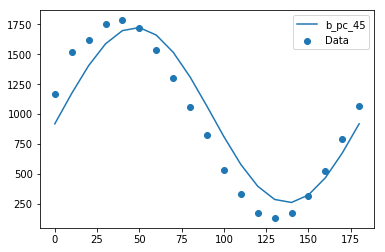

In [324]:
optimized_theta, optimized_phim = herbert_simp(beta, alpha, Nc, firstGuess=[45, 0.01, 0, 0])
print(np.degrees(optimized_theta))
print(np.degrees(optimized_phim))
#print(optimized_A)
#print(optimized_C)

plt.scatter(beta, Nc, label='Data')
plt.plot(beta, N_global(beta, A_raw, ALPHA, np.degrees(optimized_theta), np.degrees(optimized_phim), C_raw))
plt.legend(loc='best')
plt.show()

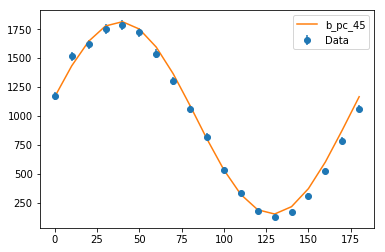

In [357]:
yerr = np.zeros(len(Nc))
for i in range(len(Nc)):
    yerr[i] = np.sqrt(Nc[i])
params = [2942.7, 45, 45, 0.01, 255.9]
params = [3523, 41, 47, 20, 66] #why is this the best? 
params = [3508, 45, 38, 20, 66] #why is this the best? 
params = [3500, 41, 47, 20, 100]

plt.errorbar(beta, Nc, label='Data', yerr=yerr, fmt='o')
plt.plot(beta, N_global(beta, params[0], params[1], params[2], params[3], params[4]))
#plt.errorbar(beta, N_global(beta, params[0], params[1], params[2], params[3], params[4]), yerr=yerr, label='Fitted function')
plt.legend(loc='best')
#plt.ylim(1020, 1050)

plt.show()

In [332]:
params, params_covariance = optimize.curve_fit(N_global, beta, Nc, p0=[4000, 45, 45, 10, 40])
#print(params)
#p0=[500, 45, 45, 20, 0.1]) this got us close
#params = [4000, 45, 45, 10, 40]

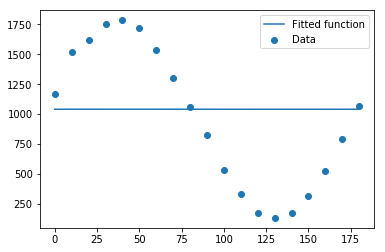

In [48]:
#plt.figure(figsize=(6, 4))
params = [4000, 45, 45, 10, 40]
plt.scatter(beta, Nc, label='Data')
#plt.plot(beta, N_global(beta, params[0], params[1], params[2], params[3], params[4]),
         #label='Fitted function')
plt.plot(beta, N_global(beta, ))
plt.legend(loc='best')
#plt.ylim(1020, 1050)

plt.show()

In [251]:
#lam = float(18.3165/18)
#error = scipy.stats.poisson(lam, size=len(beta))
xerr = beta #is this true?
yerr = np.zeros(len(Nc))
for i in range(len(Nc)):
    yerr[i] = np.sqrt(Nc[i])
    


In [67]:
def red_chisq(o, c, var, m):
    #v = n - m
    v = len(o) - m
    chi = 0
    for i in range(len(o)):
        chi = chi + ( (o[i] - c[i])**2) / (var[i]**2)
        #print(o[i]-c[i])
        #print(str(beta[i])+ ": "+str((o[i]-c[i])**2/var[i]**2))
        
    return chi / v

#red_chisq(Nc, test_func(beta, params[0], params[1], params[2], params[3]), yerr, 19, 3)

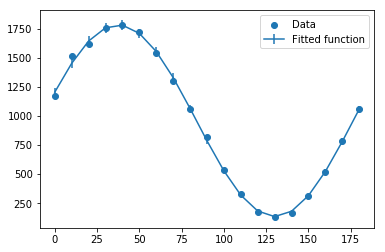

In [219]:
#plt.figure(figsize=(6, 4))
plt.scatter(beta, Nc, label='Data')
plt.errorbar(beta, test_func(beta, params[0], params[1], params[2], params[3]), yerr=yerr,
         label='Fitted function')
plt.legend(loc='best')

plt.show()

In [333]:
params

array([3523.01401462,   41.85439934,   47.41166509,   20.5141359 ,
         66.18008004])